In [1]:
from inda_mir.modeling.models import *
from inda_mir.modeling.evaluation import *
from inda_mir.loaders import load_data_partition
import pickle
import pandas as pd

In [2]:
threshold = 0.7

## Load train and validation data

In [3]:
features = pd.read_csv('inda_mir_features_with_brass_v2.csv')
validation_features = pd.read_csv('validation_features.csv')

In [4]:
X_train = features.drop(
            ['filename', 'frame', 'track_id', 'label'], axis=1
        ).to_numpy()
y_train = features['label'].to_numpy()

X_test = validation_features.drop(
            ['filename', 'frame', 'track_id', 'label'], axis=1
        ).to_numpy()
y_test = validation_features['label'].to_numpy()

In [5]:
print('Shapes:')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')
print('------')
print('Values:')
print(f'X_train: {X_train}')
print(f'y_train: {y_train}')
print(f'X_test: {X_test}')
print(f'y_test: {y_test}')

Shapes:
X_train: (15541, 253)
y_train: (15541,)
X_test: (3744, 253)
y_test: (3744,)
------
Values:
X_train: [[2.21934548e-04 1.34907373e-06 4.78560787e-06 ... 1.92560365e-05
  5.02465487e-01 2.41863906e-01]
 [1.41979835e-03 6.81587107e-06 6.53895222e-06 ... 1.56729384e-05
  3.92998040e-01 3.33826423e-01]
 [3.57312616e-04 1.91261347e-06 6.57667533e-06 ... 1.92402840e-05
  4.86686379e-01 2.51972377e-01]
 ...
 [5.67162335e-01 1.98587213e-06 9.81687549e-07 ... 2.03240162e-07
  2.45562136e-01 2.12031566e-02]
 [3.41299176e-01 2.06450886e-06 8.92546154e-07 ... 2.85963864e-07
  2.79092699e-01 2.51479298e-02]
 [1.65186316e-01 1.71456304e-06 7.65856498e-07 ... 2.67064792e-07
  3.18047345e-01 2.56410260e-02]]
y_train: ['drums' 'drums' 'drums' ... 'vocals' 'vocals' 'vocals']
X_test: [[3.16167891e-01 1.84505586e-06 8.69993091e-05 ... 3.62962396e-06
  4.97534513e-01 3.64891514e-02]
 [4.97339427e-01 2.20402353e-06 8.78154751e-05 ... 3.43646821e-06
  4.48224843e-01 3.84615399e-02]
 [3.21612328e-01 2.2

In [6]:
best_params = {
    "objective": "multiclass",
    "boosting": "gbdt",
    # "num_iterations": 2000,
    "n_estimators": 221,
    "num_leaves": 40,
    "min_child_samples": 6,
    "learning_rate": 0.2250398048171432,
    "log_max_bin": 9,
    "colsample_bytree": 0.6239201684142329,
    "reg_alpha": 0.0009765625,
    "reg_lambda": 0.48807077683502575,
    "is_unbalance": True,
    "max_depth": -1,
}

In [7]:
best_params2 = {
    "objective": "multiclass",
    "boosting": "gbdt",
    "n_estimators": 56,
    "num_leaves": 62,
    "min_child_samples": 11,
    "learning_rate": 0.085537978248575,
    "log_max_bin": 9,
    "colsample_bytree": 0.7663773657187746,
    "reg_alpha": 0.006958608037974516,
    "reg_lambda": 0.4683303882185497,
}

In [8]:
lgbm_tuned = LightGBMClassifier(**best_params)
lgbm_tuned.name = 'lgbm_retrained_finetuned'
lgbm_tuned.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64515
[LightGBM] [Info] Number of data points in the train set: 15541, number of used features: 253
[LightGBM] [Info] Start training from score -1.527383
[LightGBM] [Info] Start training from score -3.440637
[LightGBM] [Info] Start training from score -1.591013
[LightGBM] [Info] Start training from score -1.388162
[LightGBM] [Info] Start training from score -1.880170
[LightGBM] [Info] Start training from score -1.930775
[LightGBM] [Warning] No further splits with positive gain, bes

In [9]:
predictions = lgbm_tuned.predict(X_test)

[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


In [10]:
aux_dataset = validation_features[['track_id']].copy()
aux_dataset['truth'] = y_test
aux_dataset['prediction'] = predictions

In [11]:
import numpy as np

class_by_tracks = aux_dataset.groupby(['track_id']).agg({
    'truth': 'min',
    'prediction': lambda x: np.random.choice(x.mode(dropna=False))
}).reset_index()

[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


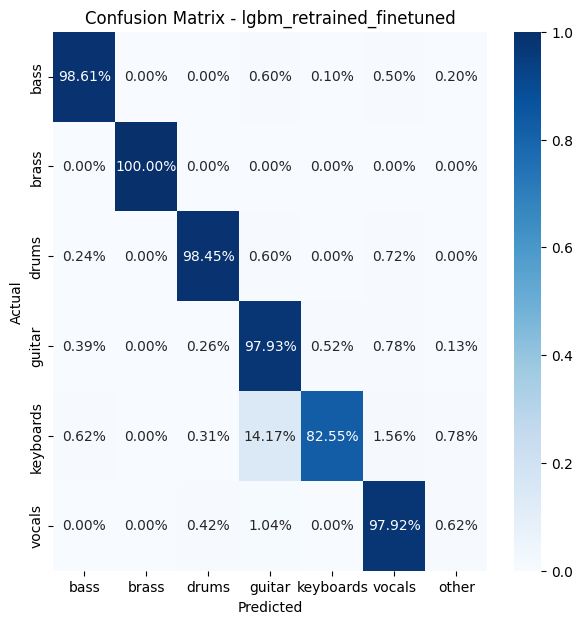

In [12]:
plot_confusion_matrix(y_test, X_test, lgbm_tuned)

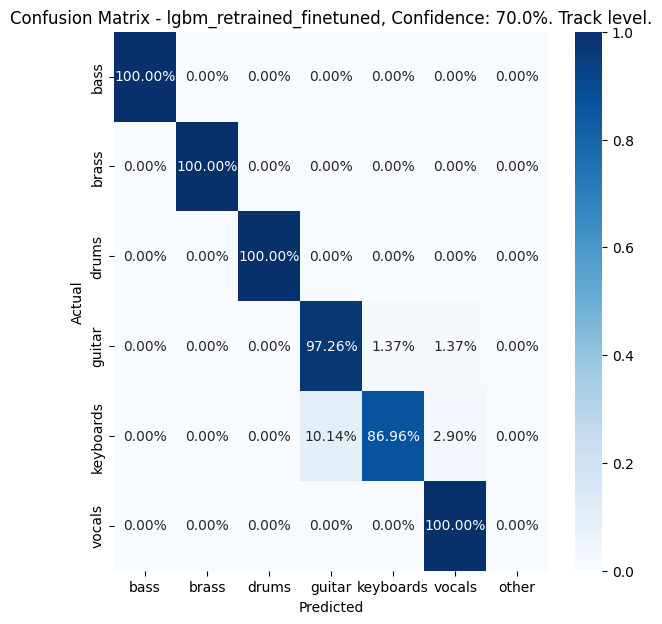

In [13]:
labels = lgbm_tuned.classes_
cm = confusion_matrix(class_by_tracks['truth'].to_numpy(), class_by_tracks['prediction'].to_numpy(), labels=labels)[: len(labels) - 1]
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(len(labels), len(labels)))
sns.heatmap(
    cm,
    annot=True,
    fmt='.2%',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels[:-1],
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {lgbm_tuned.name}, Confidence: {threshold*100}%. Track level.')
plt.show()

In [14]:
print_classification_report(class_by_tracks['truth'].to_numpy(), class_by_tracks['prediction'].to_numpy(), labels=labels)

              precision    recall  f1-score   support

        bass       1.00      1.00      1.00        72
       brass       1.00      1.00      1.00         1
       drums       1.00      1.00      1.00        74
      guitar       0.91      0.97      0.94        73
   keyboards       0.98      0.87      0.92        69
      vocals       0.95      1.00      0.98        62
       other       0.00      0.00      0.00         0

   micro avg       0.97      0.97      0.97       351
   macro avg       0.84      0.83      0.83       351
weighted avg       0.97      0.97      0.97       351



/Users/nathanfernandes/Documents/track_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nathanfernandes/Documents/track_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nathanfernandes/Documents/track_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

## Check the wrong predictions

In [15]:
class_by_tracks[class_by_tracks['prediction'] != class_by_tracks['truth']]

,track_id,truth,prediction
30,14390e83-b870-41e2-bff2-a2b52249f24b_b283a63aa...,keyboards,guitar
51,23a1bb34-da40-4df8-a0ed-741c677fc5ed_9b27adbb2...,keyboards,vocals
83,3fd3697b-edc4-40f2-b2d9-85bca65f23da_799149753...,keyboards,guitar
135,5f593c6c-8588-4bb2-b9dd-793649213aa3_5ce1a92ee...,keyboards,guitar
144,66bc6af9-12c9-4101-9dfb-6c8bfe8e866e_5afd2bac5...,guitar,keyboards
158,70c12d4a-9002-4160-97c4-0de120a13e46_379823c32...,keyboards,guitar
190,85d24294-ccc7-416d-9585-b36d4fb93668_cfcbf24de...,keyboards,guitar
204,8ecd4114-96a5-4f48-b471-c91e966136f0_85dbc5500...,keyboards,guitar
210,91647295-4765-4af8-a5c7-913363926017_db540dcd8...,keyboards,vocals
286,c5b15c23-2fee-472e-87eb-c37692ece5a7_1dd935937...,keyboards,guitar


## Compare with untuned model

In [16]:
lgbm_baseline = LightGBMClassifier()
lgbm_baseline.name = 'lgbm_retrained_baseline'
lgbm_baseline.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64515
[LightGBM] [Info] Number of data points in the train set: 15541, number of used features: 253
[LightGBM] [Info] Start training from score -1.527383
[LightGBM] [Info] Start training from score -3.440637
[LightGBM] [Info] Start training from score -1.591013
[LightGBM] [Info] Start training from score -1.388162
[LightGBM] [Info] Start training from score -1.880170
[LightGBM] [Info] Start training from score -1.930775


In [17]:
aux_dataset['prediction_base'] = lgbm_baseline.predict(X_test)
class_by_tracks_base = aux_dataset.groupby(['track_id']).agg({
    'truth': 'min',
    'prediction_base': lambda x: np.random.choice(x.mode(dropna=False))
}).reset_index()

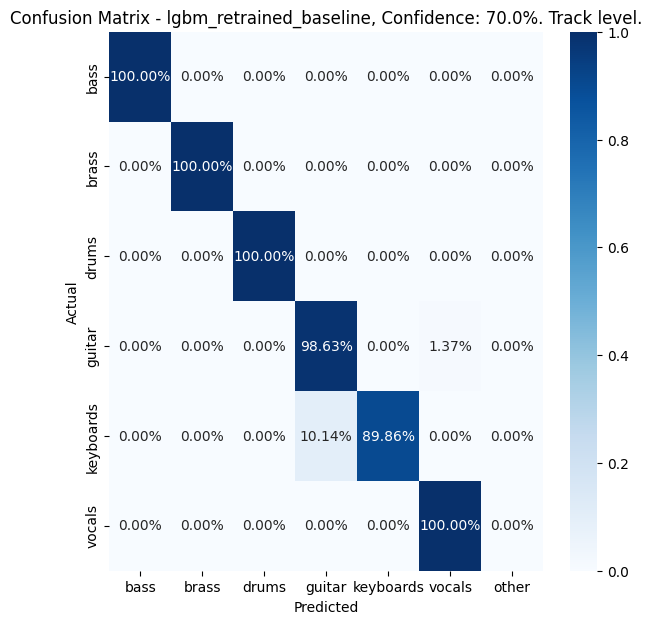

In [18]:
labels = lgbm_baseline.classes_
cm = confusion_matrix(class_by_tracks_base['truth'].to_numpy(), class_by_tracks_base['prediction_base'].to_numpy(), labels=labels)[: len(labels) - 1]
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(len(labels), len(labels)))
sns.heatmap(
    cm,
    annot=True,
    fmt='.2%',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels[:-1],
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {lgbm_baseline.name}, Confidence: {threshold*100}%. Track level.')
plt.show()

In [19]:
class_by_tracks

,track_id,truth,prediction
0,003f7822-fe56-467b-8e4a-ea0a549cfb41_bae6fbf7b...,keyboards,keyboards
1,0196ccb7-f963-4d47-8c81-9feae75d236d_bbb719b22...,vocals,vocals
2,020790b5-d850-4fd3-839c-4238a17fff53_bd7b23c14...,bass,bass
3,02d5f46d-8751-4da7-8cec-e637cb39594b_075ff8b8d...,keyboards,keyboards
4,03f2d1b8-470c-448f-9728-ddc877939ce7_1fa30a4ff...,bass,bass
...,...,...,...
346,facd34ad-a759-4ca0-a346-de0688a10750_628446206...,bass,bass
347,fb7e12ca-dd18-469c-ab77-5297d8b2651d_60020c27f...,vocals,vocals
348,fbdfd5c6-1f6f-44dc-98e9-cd0a9c8f3951_e638b5b61...,bass,bass
349,fcb814f8-c5bf-48e8-92f3-75a69b4e2790_7e21d8e67...,vocals,vocals


In [20]:
print_classification_report(class_by_tracks['truth'].to_numpy(), class_by_tracks_base['prediction_base'].to_numpy(), labels=labels)

              precision    recall  f1-score   support

        bass       1.00      1.00      1.00        72
       brass       1.00      1.00      1.00         1
       drums       1.00      1.00      1.00        74
      guitar       0.91      0.99      0.95        73
   keyboards       1.00      0.90      0.95        69
      vocals       0.98      1.00      0.99        62
       other       0.00      0.00      0.00         0

   micro avg       0.98      0.98      0.98       351
   macro avg       0.84      0.84      0.84       351
weighted avg       0.98      0.98      0.98       351



/Users/nathanfernandes/Documents/track_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nathanfernandes/Documents/track_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nathanfernandes/Documents/track_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/Users/nathanfernandes/Documents/track_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nathanfernandes/Documents/track_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


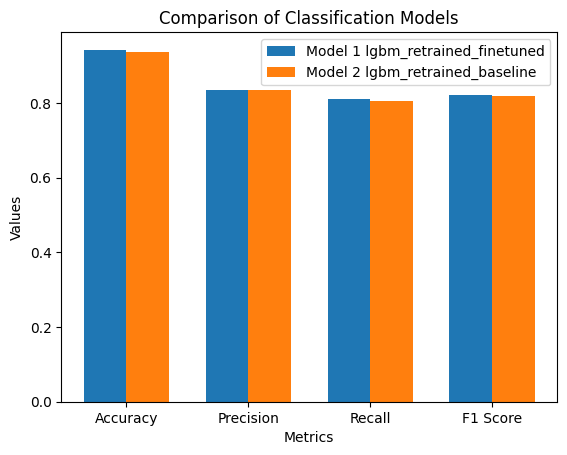

In [21]:
plot_model_comparison(lgbm_tuned, lgbm_baseline, X_test, y_test)

In [22]:


model_v1 = 'models_lgbm_oe_rs_wbrass_27102023.pkl'
with open(model_v1, 'rb') as file:
    model_v1 = pickle.load(file)
model_v1.name = 'lgbm_v1'

[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/Users/nathanfernandes/Documents/track_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nathanfernandes/Documents/track_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


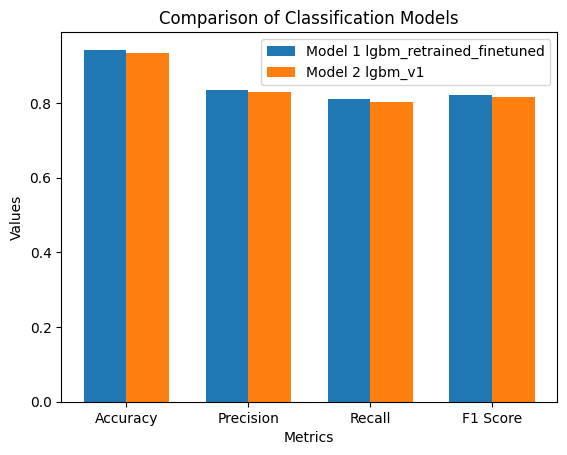

In [23]:
plot_model_comparison(lgbm_tuned, model_v1, X_test, y_test)

## Model v1 metrics

In [24]:
aux_dataset['prediction_v1'] = model_v1.predict(X_test)
class_by_tracks_v1 = aux_dataset.groupby(['track_id']).agg({
    'truth': 'min',
    'prediction_v1': lambda x: np.random.choice(x.mode(dropna=False))
}).reset_index()

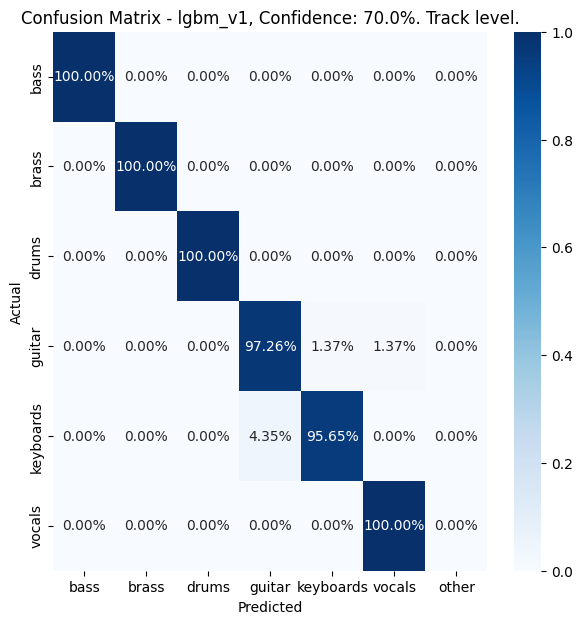

In [25]:
labels = model_v1.classes_
cm = confusion_matrix(class_by_tracks_v1['truth'].to_numpy(), class_by_tracks_v1['prediction_v1'].to_numpy(), labels=labels)[: len(labels) - 1]
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(len(labels), len(labels)))
sns.heatmap(
    cm,
    annot=True,
    fmt='.2%',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels[:-1],
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {model_v1.name}, Confidence: {threshold*100}%. Track level.')
plt.show()